In [27]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap

In [28]:
def new_grid(m, n, empty_ratio=0.1):
    """
    Creates a new grid with specified dimensions, leaving a specified rartio of cells unpopulated.

    Parameters:
    m (int): Number of rows.
    n (int): Number of columns.
    empty_ratio (float, optional): Proportion of grid cells to leave unpopulated.
    Defaults to 0.1.

    Returns:
    numpy.ndarray: A 2D grid of shape (m, n) where populated cells contain 1 
    and unpopulated cells contain NaN.
    """
    grid = np.ones([m, n])
    num_empty = int(n * m * empty_ratio)
    
    # Randomly assign empty spaces
    empty_positions = np.random.choice(n * m, num_empty, replace=False)
    for idx in empty_positions:
        # Set row index to be integer division by m, remainder is column index 
        grid[idx // m, idx % m] = np.nan 
    
    return grid

def add_amenities(grid, amenities):
    """
    Adds amenities to unpopulated spaces in the grid.

    Parameters:
    grid (numpy.ndarray): A 2D grid where populated spaces are represented by 1 and  
    unpopulated spaces are represented by NaN.
    amenities (int): The number of amenities to add to the grid (if this number exceeds 
    the available unpopulated spaces, only the number of available spaces is added.)

    Returns:
    numpy.ndarray: The updated grid with amenities added. Amenity cells are marked with -1.
    """
    # Get empty position indices by looking for NaNs
    empty_positions = np.argwhere(np.isnan(grid))
    
    # Number of amenities set to be minimum of entered argument and number of empty slots
    num_amenities = min(amenities, len(empty_positions))
    # Randomly choose from empty slots
    amenity_indices = np.random.choice(len(empty_positions), num_amenities, replace=False)
    # We can remove this line later
    # print(f"Positions to add amenities: {amenity_indices}")
    
    # Iterate through chosen empty positions to set amenity values
    for idx in amenity_indices:
        position = empty_positions[idx]
        # Use -1 to represent an amenity 
        # This should work since houses will never have a negative price
        grid[position[0], position[1]] = -1  
    
    return grid

def initial_price_dist(m, n, v, amenities, empty_ratio=0.1):
    """
    Initializes the grid representing house prices, unpopulated spaces, and amenities.

    Parameters:
    m (int): Number of rows.
    n (int): Number of columns.
    v (float): The initial price multiplier for populated spaces (populated spaces are set 
    to `v`, unpopulated spaces stay NaN.)
    amenities (int): The number of amenities to add to the grid.
    empty_ratio (float, optional): Proportion of the grid to leave unpopulated. 
    Defaults to 0.1.

    Returns:
    numpy.ndarray: A 2D grid with houses all the same price, empty space and amenities.
    """
    houses = v * new_grid(m, n, empty_ratio)
    # Add "amenities" number of amenities within the empty grid points
    houses = add_amenities(houses, amenities)

    return houses


def plot_grid(grid):
    '''
    Plot grid with unpopulated squares in white, amenities in red, and high values in yellow.
    
    Parameters:
    grid (numpy.ndarray): A 2D array where NaN values represent unpopulated spaces and
    -1 values represent amenities (positive values are house prices).

    Returns:
    matplotlib.image.AxesImage: The plotted image object.
    '''

    # Colour map for house prices only
    cmap = plt.cm.cividis.copy()
    
    # Set pink for NaN values 
    cmap.set_bad(color='white')
    
    # Calculate the minimum and maximum values in the grid, excluding NaN and -1 values (amenities)
    non_empty_values = grid[(grid != -1)]
    min_value = np.nanmin(non_empty_values)
    max_value = np.nanmax(non_empty_values)
    # Plot house grid using min_value for vmin and max_value for vmax 
    # This is to make sure NaNs and amenities don't distort scale
    img = plt.imshow(grid, cmap=cmap, vmin=min_value, vmax=max_value, interpolation='nearest') 
    
    # Colour map which will set only -1 to red and the rest to transparent white
    # All entries start as transparent 
    new_colours = np.ones((256, 4))  
    # Set the first color to black (for value -1)
    new_colours[0] = [1, 0, 0, 1]  
    # Set all other colors to transparent white
    new_colours[1:] = [1, 1, 1, 0]  
    new_cmap = ListedColormap(new_colours)
    # Make a mask for amenities and set them to a different colour (used blue)
    amenities_mask = grid != -1
    plt.imshow(amenities_mask, cmap=new_cmap)  

    # Add colour bar for the house price values
    plt.colorbar(img)  

    return img
    
def initial_affluence_dist(initial_prices, a, p):
    '''
    Initialize affluence of householders as their own grid corresponding to populated spaces 
    
    Parameters:
    initial_prices (numpy.ndarray): A 2D array representing initial set house prices.
    a (list): An array representing three different affluence group parameters. 
    p (list): An array of the proportions corresponding to each affluence group. 

    Returns:
    numpy.ndarray: A 2D array of the same shape as `initial_prices` where populated house 
    cells contain rabdomly assigned affluence group values (and unpopulated cells / 
    amenities are set to NaN.)
    '''
    m = initial_prices.shape[0]
    n = initial_prices.shape[1]
    
    # Initialize an empty affluence grid with NaNs for empty cells
    affluence_grid = np.full(initial_prices.shape, np.nan)  
    
    # Loop through each cell in the house_vals grid
    for i in range(m):
        for j in range(n):
            # Only assign affluence if the square is populated (-1 < 0, otherwise point populated)
            if initial_prices[i, j] > 0: 
                affluence_grid[i, j] = np.random.choice(a, p=p)

    return affluence_grid

In [29]:
# Functions for calculating house values
       
# Note: this is including the house itself. Do we want that?        
def neighborhood_average(i, j, m, n, grid):
    """
    Calculates the average value of neighboring cells within a set radius.

    Parameters:
    i (int): Row index of the current cell.
    j (int): Column index of the current cell.
    m (int): Number of rows.
    n (int): Number of columns.
    grid (numpy.ndarray): A 2D array representing house prices, empty space and amenities.

    Returns:
    float: The average of valid neighboring values, or the value of the current cell if no 
    valid neighbors exist (excludes NaN values and amenities in the average calculation.)
    """
    row_min = max(0, i - 2)
    row_max = min(m-1, i + 2)
    
    col_min = max(0, j - 2)
    col_max = min(n-1, j + 2)
    
    neighborhood = grid[row_min:row_max+1, col_min:col_max+1]
    
    # Mask out NaNs and amenities
    valid_neighbors = neighborhood[(~np.isnan(neighborhood)) & (neighborhood != -1)]
    
    # Calculate the mean of valid neighbors (ignores empty squares and amenities)
    if valid_neighbors.size > 0:
        return valid_neighbors.mean()
    else:
        # If the square is empty or an amenity it stays the same 
        return grid[i, j]
       
def amenities_impact(house_vals, x, r):
    """
    Calculates the total value added to a house by amenities within a given radius.

    Parameters:
    house_vals (numpy.ndarray): A 2D array representing house prices, empty space and amenities.
    x (list or tuple): A pair of integers (i, j) representing the coordinates of the house 
    for which the nearby amenity impact is calculated.
    r (int): The radius within which to consider amenities. Value is measured using Manhattan 
    norm.

    Returns:
    float: The total value added by amenities within the Manhattan radius `r`. The closer an amenity 
    is, the more value it adds (decreases linearly with distance.)
    """
    i, j = x[0], x[1]
    m, n = house_vals.shape[0], house_vals.shape[1]
    
    row_min = max(0, i - r)
    row_max = min(m-1, i + r)
    
    col_min = max(0, j - r)
    col_max = min(n-1, j + r)
    
    value_added = 0
    
    for k in range(row_min, row_max+1):
        for l in range(col_min, col_max+1):
            if house_vals[k, l] == -1:
                # The closer it is, the more value it adds 
                distance = abs(k - i) + abs(l - j)
                value_added += max(0, r + 1 - distance)/r
                
    return value_added

def update_house_prices(house_vals, affluence_grid, weights, r):
    """
    Updates the house values by incorporating household affluence, neighborhood average prices, 
    and the impact of nearby amenities.

    Parameters:
    house_vals (numpy.ndarray): A 2D array representing house prices, empty space and amenities.
    affluence_grid (numpy.ndarray): A 2D array representing the affluence of householders where
    each cell contains an affluence value for the corresponding house.
    weights (list): A pair of weights that determine the relative importance of the neighborhood 
    average price and the amenities impact in the price update.
    r (int): The radius within which to consider the impact of amenities when updating house prices.

    Returns:
    numpy.ndarray: A 2D array representing the updated house values.
    """
    updated_houses = house_vals.copy()
    
    m = house_vals.shape[0]
    n = house_vals.shape[1]

    for i in range(m):
        for j in range(n):
            # Skip updates for empty spaces and amenities
            if np.isnan(house_vals[i, j]) or house_vals[i, j] == -1:
                # Go to next iteration if NaN or -1
                continue
            # Otherwise update as normal
            updated_houses[i, j] = (affluence_grid[i, j] 
            + weights[0] * neighborhood_average(i, j, m, n, house_vals) 
            + weights[1] * amenities_impact(house_vals, (i, j), r))

    return updated_houses

In [30]:
# Functions for choosing a random position relative to a position and considering a swap between two the positions 

def random_position(i, j, m, n):
    """
    Pick a random position to compare to different from the specified position.

    Parameters:
    i (int): Row index of the current position.
    j (int): Column index of the current position.
    m (int): Number of rows.
    n (int): Number of columns.

    Returns:
    tuple: A tuple (rand_row, rand_col) representing the random position.
    """
    # Ensures this will keep going until the position is not the same as the one we want to comoare to
    while True:
        rand_row = np.random.randint(0, m - 1)
        rand_col = np.random.randint(0, n - 1)
        # Ensures it is not the same as the current position
        if (rand_row, rand_col) != (i, j):
            return rand_row, rand_col
    
# Need to update this function to value amenities!!!
def perform_swaps(house_vals, affluence_grid, x, rand_pos):
    """
    Check 10 potential householder swaps and execute "best" swap if satisfaction improves.
    
    Parameters:
    house_vals (numpy.ndarray): A 2D array representing house values.
    affluence_grid (numpy.ndarray): A 2D array representing affluence values.
    x (tuple): The fixed comparison position.
    rand_pos (list): A list of random positions to compare against.

    Returns:
    numpy.ndarray: The updated affluence grid after performing the swap (if any).
    """
    # List of deltas 
    delta_vec = []
    
    # Consider each position separately 
    for y in rand_pos:
        # Calculate the change in "satisfaction" if two householders swap
        delta = ((affluence_grid[x] - house_vals[x])**2 + (affluence_grid[y] - house_vals[y])**2 
                - (affluence_grid[x] - house_vals[y])**2 - (affluence_grid[y] - house_vals[x])**2)
        delta_vec.append(delta)

    # Find the positive deltas (if there are any)
    positive_deltas = [(delta, y) for delta, y in zip(delta_vec, rand_pos) if delta > 0]

    # Only perform a swap if there is a positibe delta 
    if positive_deltas:
    # Select the y corresponding to the maximum positive delta
        best_delta, best_y = max(positive_deltas, key=lambda pair: pair[0])
        affluence_grid[x], affluence_grid[best_y] = affluence_grid[best_y], affluence_grid[x]

    return affluence_grid

In [31]:
# Iteration function 

def new_iteration(house_vals, affluence_grid):
    """
    Parameters:
    house_vals (numpy.ndarray): A 2D array representing house values.
    affluence_grid (numpy.ndarray): A 2D array representing affluence values.
    weights (list): A pair of weights that determine the relative importance of the neighborhood 
    average price and the amenities impact in the price update.
    r (int): Radius used to calculate the impact of amenities.

    Returns:
    tuple: A tuple of arrays containing updated house values and the updated affluence grid.

    """
    
    m = house_vals.shape[0]
    n = house_vals.shape[1]
        
    # Iterate over each populated element in the array
    for i in range(m):
        for j in range(n):
            # Skip unpopulated or amenity squares
            if house_vals[i, j] <= 0:
                # Continue skips to next iteration
                continue
            
            x = (i,j)
            # List of random positions to consider 
            rand_pos = []
            # Consider 10 different positions 
            for k in range(10):
            # Find a random populated cell to compare for a potential swap
                while True:
                    rand_i, rand_j = random_position(i, j, m, n)
                    # Only swap with another populated square
                    if house_vals[rand_i, rand_j] > 0 and (rand_i, rand_j) not in rand_pos:
                        # While loop exited only if the square is not NaN or -1
                        break
                # Add to list of positions to consider 
                rand_pos.append((rand_i, rand_j))
            affluence_grid = perform_swaps(house_vals, affluence_grid, x, rand_pos)
            
    # Update house prices
    house_vals = update_house_prices(house_vals, affluence_grid, weights, r)

    return house_vals, affluence_grid

In [32]:
# Add new houses in empty spaces or modify existing house prices 

def add_new_houses(house_vals, affluence_grid, a, p, num_houses=1, random=True, pos=None, value=5):
    """
    Add new houses, either by choosing num_houses random empty indices or choosing a position.
    
    Parameters:
    house_vals (np.ndarray): 2D array representing house values.
    affluence_grid (np.ndarray): 2D array representing affluence values.
    a (list): An array representing three different affluence group parameters. 
    p (list): An array of the proportions corresponding to each affluence group. 
    num_houses (int): Number of new houses to add. Defaults to 1.
    random (bool): Whether to add houses at random empty positions. Defaults to True.
    pos (list): Specific positions to add houses (only used if `random=False`).
    value (float): Value to assign to the newly added houses in `house_vals`. Defaults to 5.

    tuple: A tuple of arrays containing updated house values and the updated affluence grid.
    """
    positions_added=[]
    
    if random == True:
        # Get empty position indices by looking for NaNs
        empty_positions = np.argwhere(np.isnan(house_vals))
        # Ensure there are enough empty positions to choose from
        if len(empty_positions) >= num_houses:
            # Choose unique random indices from empty_positions
            rand_idx = empty_positions[np.random.choice(len(empty_positions), size=num_houses, replace=False)]
            # print(f"Chosen empty positions to add houses with value {value}:", rand_idx)
            for idx in rand_idx:
                house_vals[tuple(idx)] = value
                positions_added.append(tuple(idx))
        else:
            print(f"Not enough empty positions to choose {num_houses}. Available:", len(empty_positions))
    
    else:
        for idx in pos:
            house_vals[tuple(idx)] = value  
            positions_added.append(tuple(idx))
    
    for idx in positions_added:
        affluence_grid[idx] = np.random.choice(a, p=p)
            
    return house_vals, affluence_grid


def modify_existing_prices(house_vals, num_houses=1, random=True, pos=None, new_value=5):
    """
    Modify the prices of existing houses in the grid, either by selecting random valid indices 
    or by specifying positions explicitly.
    
    Args:
    house_vals (np.ndarray): 2D array representing house values.
    num_houses (int): Number of existing houses to modify (only applies if random=True). Defaults to 1.
    random (bool): Whether to modify prices at random valid positions. Defaults to True.
    pos (list): List of positions to modify (only used if random=False). 
    new_value (float): Value to assign to the modified houses in house_vals. Defaults to 5.
    """
    if random == True:
        valid_positions = np.argwhere((~np.isnan(house_vals)) & (house_vals != -1))
        if len(valid_positions) < num_houses:
            raise ValueError(f"Not enough valid positions to modify {num_houses}. Available: {len(valid_positions)}")
        rand_idx = valid_positions[np.random.choice(len(valid_positions), size=num_houses, replace=False)]
        # print(f"Chosen houses to modify price to {new_value}:", rand_idx)
        for idx in rand_idx:
            house_vals[tuple(idx)] = new_value
    
    else:
        for idx in pos:
            house_vals[tuple(idx)] = new_value
    
    return house_vals
    

array([[ 5.,  5., nan, ...,  5.,  5.,  5.],
       [nan,  5.,  5., ...,  5.,  5.,  5.],
       [ 5., nan,  5., ..., nan,  5.,  5.],
       ...,
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       [nan, nan,  5., ...,  5.,  5.,  5.],
       [ 5.,  5.,  5., ..., nan,  5., nan]])

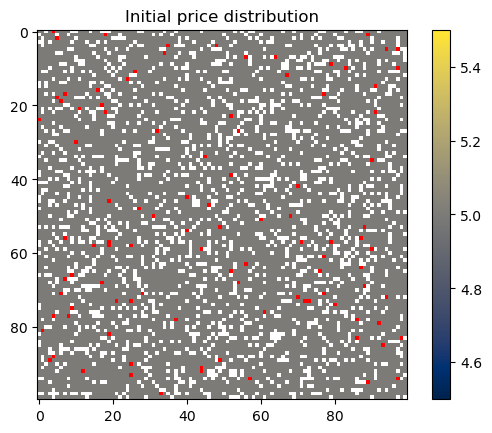

Initial affluence distribution:


array([[0.1, 0.5, nan, ..., 1. , 1. , 0.5],
       [nan, 0.5, 1. , ..., 1. , 0.5, 0.1],
       [0.1, nan, 0.1, ..., nan, 0.1, 0.1],
       ...,
       [0.1, 0.5, 0.1, ..., 0.1, 0.1, 1. ],
       [nan, nan, 0.1, ..., 0.5, 0.5, 0.5],
       [0.1, 0.5, 0.1, ..., nan, 0.5, nan]])

In [33]:
# Set board size
m = 100
n = 100

# Set parameters
a = [1,0.5,0.1] # Affluence group parameters 
p = [0.1, 0.4, 0.5] # Initial affluence proportions 
v = 5 # Initial house price
weights = [0.75, 0.75] # Inflationary parameter and amenities parameter
empty_ratio = 0.2 # Proportion of grid empty
amenities = m # Number of amenities
r = 4 # Radius to consider amenities in

# Initialize house price grid 
initial_prices = initial_price_dist(m, n, v, amenities, empty_ratio)

display(initial_prices)
plot_grid(initial_prices)
plt.title("Initial price distribution")
plt.show()

print("Initial affluence distribution:")
# Initialize affluence grid 
affluence_grid = initial_affluence_dist(initial_prices, a, p)
display(affluence_grid)

Testing first house values calculation:


array([[4.0375, 4.625 ,    nan, ..., 4.75  , 4.75  , 4.25  ],
       [   nan, 4.4375, 5.3125, ..., 4.9375, 4.25  , 3.85  ],
       [3.85  ,    nan, 4.4125, ...,    nan, 4.0375, 3.85  ],
       ...,
       [3.85  , 4.25  , 3.85  , ..., 4.225 , 4.0375, 4.75  ],
       [   nan,    nan, 3.85  , ..., 4.4375, 4.25  , 4.25  ],
       [3.85  , 4.25  , 3.85  , ...,    nan, 4.25  ,    nan]])

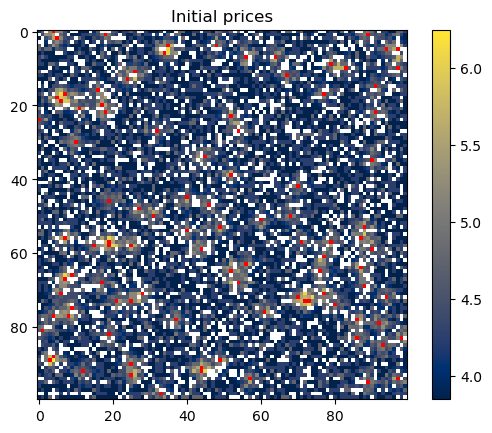

In [34]:
# Test the new functions

house_vals = update_house_prices(initial_prices, affluence_grid, weights, r) 
# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")

print("Testing first house values calculation:")
display(house_vals)

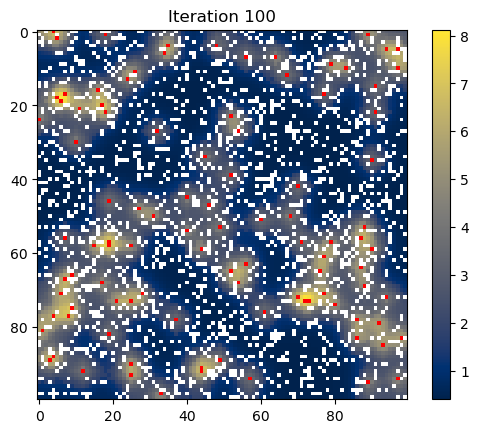

In [35]:
# Animation cell 

# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")
plt.pause(0.5) 
clear_output(wait=True) 

# Plot the iterations 
n_steps = 100
for i in range(n_steps):
   house_vals, affluence_grid = new_iteration(house_vals, affluence_grid)
   img = plot_grid(house_vals)  
   plt.title(f"Iteration {i + 1}")
   plt.pause(0.001)  
   clear_output(wait=True) 

In [36]:
# Implementing adding houses and modifying houses functions

# Initialize house price grid 
initial_prices = initial_price_dist(m, n, v, amenities, empty_ratio)

# Initialize affluence grid 
affluence_grid = initial_affluence_dist(initial_prices, a, p)

house_vals = update_house_prices(initial_prices, affluence_grid, weights, r) 

# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")
plt.pause(1) 
clear_output(wait=True) 

# Plot the iterations 
# Add 1000 random houses with price 5 at iteration 25
# Modify 1000 random existing houses to price 10 at iteration 50
n_steps = 100
for i in range(n_steps):
    if i == 25:
        house_vals, affluence_grid = add_new_houses(
            house_vals, affluence_grid, a, p, num_houses=1000, random=True, pos=None, value=5
            )
    if i == 50:
        house_vals = modify_existing_prices(
            house_vals, num_houses=1000, random=True, pos=None, new_value=10
        )
    house_vals, affluence_grid = new_iteration(house_vals, affluence_grid)
    img = plot_grid(house_vals)  
    plt.title(f"Iteration {i + 1}")
    plt.pause(0.001)  
    clear_output(wait=True) 

KeyboardInterrupt: 